![](./resources/System_v1_inference_header.png)

This notebook contains a short demo on how to use the WorldCereal system to generate a temporary crop extent and crop type map, using default models trained by the WorldCereal consortium.

# Content

- [Before you start](#before-you-start)
- [1. Define region of interest](#1.-Define-a-region-of-interest)
- [2. Generate default temporary crop extent product](#2.-Generate-default-temporary-crop-extent-product)
- [3. Generate default crop type product](#3.-Generate-default-crop-type-product)
- [4. Explore available reference data](#4.-Explore-available-reference-data)

In [1]:
%load_ext autoreload
%autoreload 2

# Before you start

In order to run this notebook, you need to create an account on the Copernicus Data Space Ecosystem,
by completing the form [HERE](https://identity.dataspace.copernicus.eu/auth/realms/CDSE/login-actions/registration?client_id=cdse-public&tab_id=eRKGqDvoYI0).


In [2]:
# First we import the necessary modules to run this notebook

from pathlib import Path

from worldcereal.utils.map import (get_ui_map, get_bbox_from_draw,
                                   visualize_products, postprocess_product,
                                   show_color_legend)
from worldcereal.job import generate_map, WorldCerealProduct
from worldcereal.seasons import get_processing_dates_for_extent

OUTDIR = Path('/vitodata/worldcereal/test/demo-inference')

# 1. Define a region of interest

When running the code snippet below, an interactive map will be visualized.
Click the Rectangle button on the left hand side of the map to start drawing your region of interest.
When finished, execute the second cell to store the coordinates of your region of interest. 

In [3]:
m, dc = get_ui_map()
m

Map(center=[51.1872, 5.1154], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

In [4]:
# retrieve bounding box from drawn rectangle
spatial_extent, bbox, poly = get_bbox_from_draw(dc)

Your area of interest: (4.527225, 51.159861, 4.585762, 51.184508)
Area of processing extent: 11.73 km²


# 2. Generate default temporary crop extent product

The temporary crops extent product is defined as a binary mask indicating the presence of temporary crops. This product is generated for a full year. The exact timing of the processing period is defined by the WorldCereal crop calendars.

In the cell below we specify some input parameters (year, season, output path and product type) and then launch an OpenEO processing job which will generate our map:

In [ ]:
# ---------------------------------------------
# DEFINE INPUTS FOR GENERATING THE MAP

# Our year of interest:
year = 2021
# The temporary crop extent product is generated once per year. 
# The processing period of this product is defined by the tc-annual season:
season = "tc-annual"
# Output path where the generated map will be stored:
output_path = str(OUTDIR / 'Belgium_temporal_crop.tif')
# Type of product to be generated. For now, we only have the choice between
# two pre-trained models, i.e. a CROPLAND model and a CROPTYPE model.
product_type = WorldCerealProduct.CROPLAND

# ---------------------------------------------

# Get the processing period for the temporary crops product
# based on the WorldCereal crop calendars:
temporal_extent = get_processing_dates_for_extent(spatial_extent, year, season)

# check whether we have a valid spatial extent
if spatial_extent is None:
    raise ValueError("Please first select a processing area using the cells above.")

# We call the function to generate the map on the CDSE backend using OpenEO.
# Note that if we do not specify a "product_type" in the arguments of the
# generate_map function, the temporary crops product will be generated based on
# the default model as provided by the WorldCereal consortium.
# When output path is specified, the results will be automatically downloaded to the
# specified location.
Path(output_path).parent.mkdir(parents=True, exist_ok=True)
results = generate_map(
    spatial_extent, temporal_extent, output_path=output_path,
    product_type=product_type)

# check content of "results"
print("----------------------------------")
print(f"OpenEO job ID: {results.job_id}")
print(f"URL to download the map product: {results.product_url}")

After the OpenEO processing job ends, we get to see the OpenEO job ID of the processing job in which our map has been generated and also a direct download link to get access to our generated map. You can login to the [OpenEO web editor](https://openeo.dataspace.copernicus.eu/) on the Copernicus Data Space Ecosystem, and, using the job ID, retrieve more information about this processing job (logs, metadata and direct access to the generated product).

The resulting map will be written to disk (specified by output_path).
There are three options to visualize the product:
- using the code cell below, we visualize the output directly in this notebook.
- visualize the map directly through the [OpenEO web editor](https://openeo.dataspace.copernicus.eu/). After logging in, look for the processing job that was used to generate the map (use the job ID) and click the "View results" button for direct visualization.
- visualize the downloaded product in QGIS locally.

ValueError: RGBA sequence should have length 3 or 4

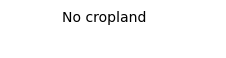

In [14]:
# In this cell, we prepare the generated map for visualization.
# Post-processing includes separating the classification labels and probabilities into separate files and assigning an easily interpretable color code to these products.
# During post-processing, we also clean the output map through a spatial majority filter.
output_path = str(OUTDIR / 'Belgium_temporal_crop.tif')
product = "temporary-crops"
outfiles = postprocess_product(output_path, product=product)
show_color_legend(product)
m = visualize_products(outfiles)
m


# 3. Generate default crop type product

The WorldCereal consortium has pre-trained a default crop type model, containing the following crops:
- Barley
- Maize
- Millet/Sorghum
- Rapeseed
- Soybean
- Sunflower
- Wheat
- Other crop

This product is generated for a specific growing season. For each region in the world, the WorldCereal system has pre-defined two major growing seasons (tc-s1 and tc-s2) in the WorldCereal crop calendars. Seasons are ordered chronologically, i.e. tc-s1 is the season which ends first in a calendar year.

Note that the default WorldCereal crop type map is automatically masked using the binary temporary crop extent product, which is generated before the actual crop type product in the same workflow. This means that if you are interested in the crop type map, you do not need to generate the temporary crop extent product separately.

In the cell below we specify some input parameters (year, season, output path and product type) and then launch an OpenEO processing job which will generate our map:

In [5]:
# ---------------------------------------------
# DEFINE INPUTS FOR GENERATING THE MAP

# Our year of interest:
year = 2021
# The crop type product can be generated for each individual growing season.
# By default, the WorldCereal system defines two growing seasons per year
# for each location on the planet, indicated by "tc-s1" and "tc-s2".
# Here, we choose the first season:
season = "tc-s1"
# Output path where the generated map will be stored:
output_path = str(OUTDIR / 'Belgium_crop_type.tif')
# Type of product to be generated. For now, we only have the choice between
# two pre-trained models, i.e. a CROPLAND model and a CROPTYPE model.
product_type = WorldCerealProduct.CROPTYPE

# ---------------------------------------------

# Get the processing period for the temporary crops product
# based on the WorldCereal crop calendars:
temporal_extent = get_processing_dates_for_extent(spatial_extent, year, season)

# check whether we have a valid spatial extent
if spatial_extent is None:
    raise ValueError("Please first select a processing area using the cells above.")

# We call the function to generate the map on the CDSE backend using OpenEO.
# Note that if we do not specify a "product_type" in the arguments of the
# generate_map function, the temporary crops product will be generated based on
# the default model as provided by the WorldCereal consortium.
# When output path is specified, the results will be automatically downloaded to the
# specified location.
Path(output_path).parent.mkdir(parents=True, exist_ok=True)
results = generate_map(
    spatial_extent, temporal_extent, output_path=output_path,
    product_type=product_type)

# check content of "results"
print("----------------------------------")
print(f"OpenEO job ID: {results.job_id}")
print(f"URL to download the map product: {results.product_url}")

2024-07-02 21:36:48.395 | INFO     | worldcereal.seasons:doy_from_tiff:128 - Loading DOY data from: S1_EOS_WGS84.tif


Derived the following period for processing: 2020-08-06 00:00:00 - 2021-08-05 00:00:00
Authenticated using refresh token.
Selected orbit direction: ASCENDING from max accumulated area overlap between bounds and products.


0:00:00 Job 'j-2407026d9ecd4c3490671ac857ec8738': send 'start'
0:00:28 Job 'j-2407026d9ecd4c3490671ac857ec8738': created (progress 0%)
0:00:34 Job 'j-2407026d9ecd4c3490671ac857ec8738': created (progress 0%)
0:00:40 Job 'j-2407026d9ecd4c3490671ac857ec8738': created (progress 0%)
0:00:48 Job 'j-2407026d9ecd4c3490671ac857ec8738': created (progress 0%)
0:00:58 Job 'j-2407026d9ecd4c3490671ac857ec8738': created (progress 0%)
0:01:12 Job 'j-2407026d9ecd4c3490671ac857ec8738': running (progress N/A)
0:01:27 Job 'j-2407026d9ecd4c3490671ac857ec8738': running (progress N/A)
0:01:47 Job 'j-2407026d9ecd4c3490671ac857ec8738': running (progress N/A)
0:02:13 Job 'j-2407026d9ecd4c3490671ac857ec8738': running (progress N/A)
0:02:47 Job 'j-2407026d9ecd4c3490671ac857ec8738': running (progress N/A)
0:03:25 Job 'j-2407026d9ecd4c3490671ac857ec8738': running (progress N/A)
0:04:13 Job 'j-2407026d9ecd4c3490671ac857ec8738': running (progress N/A)
0:05:12 Job 'j-2407026d9ecd4c3490671ac857ec8738': running (progres

INFO:openeo.rest.job:Downloading Job result asset 'openEO_2020-01-01Z.tif' from https://openeo.creo.vito.be/openeo/jobs/j-2407026d9ecd4c3490671ac857ec8738/results/assets/ZGNjYWI2ZDktODQ2Yy00OGE5LTlkOTQtNDk3MTQ2Y2IyMjg1/06e35c93dd3f2ade203f30ff3ae97b55/openEO_2020-01-01Z.tif?expires=1720554798 to /vitodata/worldcereal/test/demo-inference/Belgium_crop_type.tif


----------------------------------
OpenEO job ID: j-2407026d9ecd4c3490671ac857ec8738
URL to download the map product: https://openeo.creo.vito.be/openeo/jobs/j-2407026d9ecd4c3490671ac857ec8738/results/assets/ZGNjYWI2ZDktODQ2Yy00OGE5LTlkOTQtNDk3MTQ2Y2IyMjg1/8d6adef26c53a3f95f5fab56c6b4aff9/openEO_2020-01-01Z.tif?expires=1720554800


In [7]:
# In this cell, we prepare the generated map for visualization.
# Post-processing includes separating the classification labels and probabilities into separate files and assigning an easily interpretable color code to these products.
# During post-processing, we also clean the output map through a spatial majority filter.
output_path = str(OUTDIR / 'Belgium_crop_type.tif')
product = "croptype"
outfiles = postprocess_product(output_path, product=product)
show_color_legend(product)
m = visualize_products(outfiles)
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

# 3. Explore available reference data

To gain an understanding of how much local training data was available to the classification model that generated the maps in your area of interest, we use the API of the WorldCereal Reference Data Module (RDM) to check which datasets (collections) intersect with your area of interest.

The RDM can also be accessed through a [dedicated user interface](https://ewoc-rdm-ui.iiasa.ac.at/map) in case you wish to explore further.

In case you would like to test multiple regions of interest, execute the first two cells in [this section](#1.-Define-a-region-of-interest) of the notebook.

In [ ]:
import sys
sys.path.append('/home/jeroendegerickx/git/worldcereal/worldcereal-classification/notebooks')

from utils import rdm_collection_request

# by default, the collection request uses a buffer around the requested bounding box of 250 km
# the buffer can be adjusted by specifying the buffer parameter (in meters)
col_ids = rdm_collection_request(poly)
